# MNIST Generator

We want the MIL datasets to be identical from run to run. To do this, we'll produce CSVs with bag indices and labels. This notebook does it for MNIST.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from tensorflow.keras.datasets import mnist

# Set random seeds for consistency
random.seed(42)
np.random.seed(42)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


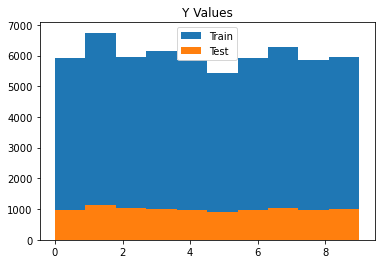

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

plt.hist(y_train)
plt.hist(y_test)
plt.legend(['Train', 'Test'])
plt.title('Y Values')
plt.show()
plt.close()

In [3]:
def pad(arr, max_size):
  p = np.empty(max_size - arr.shape[0])
  p.fill(-1)
  return np.concatenate([arr, p])

def bag_generator(x, y, get_label, min_size=3, max_size=7):
  x_shuf, y_shuf = sklearn.utils.shuffle(np.arange(x.shape[0]), y)

  x_bags = []
  y_bags = []
  
  i = 0
  
  while (x_shuf.shape[0] - i) > max_size:
    size = random.randrange(min_size, min(max_size, x_shuf.shape[0] - i - min_size))
    x_bags.append(pad(x_shuf[i:i + size], max_size))
    y_bags.append(get_label(y_shuf[i:i + size]))
    i += size

  x_bags.append(pad(x_shuf[i:], max_size))
  y_bags.append(get_label(y_shuf[i:]))

  return np.array(x_bags).astype(int), np.array(y_bags).astype(int)

def contains_zero(labels):
  return np.any(np.array(labels) == 0).astype(int)


x_train_bags, y_train_bags = bag_generator(x_train, y_train, contains_zero)
x_test_bags, y_test_bags = bag_generator(x_test, y_test, contains_zero)


print(f'train: pos={y_train_bags.sum()}, neg={y_train_bags.shape[0] - y_train_bags.sum()}, %={y_train_bags.sum() / y_train_bags.shape[0] * 100:.2f}')
print(f'test : pos={y_test_bags.sum()}, neg={y_test_bags.shape[0] - y_test_bags.sum()}, %={y_test_bags.sum() / y_test_bags.shape[0] * 100:.2f}')

train: pos=4929, neg=8365, %=37.08
test : pos=831, neg=1402, %=37.21


In [4]:
train = np.concatenate([y_train_bags[:, np.newaxis], x_train_bags], axis=1)
test = np.concatenate([y_test_bags[:, np.newaxis], x_test_bags], axis=1)

columns = ['y'] + [ f'x{i}' for i in range(train.shape[1] - 1)]

train_df = pd.DataFrame(train, columns=columns)
test_df = pd.DataFrame(test, columns=columns)

train_df.to_csv('data/mnist_train.csv', index=False)
test_df.to_csv('data/mnist_test.csv', index=False)